In [1]:
!pip install efficientnet_pytorch torchtoolbox
!pip install chart_studio

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet

%matplotlib inline

In [3]:
warnings.simplefilter("ignore")


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(47)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MelanomaDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        imfolder: str,
        train: bool = True,
        transforms=None,
        meta_features=None,
    ):
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features

    def __getitem__(self, index):
        im_path = os.path.join(
            self.imfolder, self.df.iloc[index]["image_name"] + ".jpg"
        )
        x = cv2.imread(im_path)
        meta = np.array(
            self.df.iloc[index][self.meta_features].values, dtype=np.float32
        )

        if self.transforms:
            x = self.transforms(x)

        if self.train:
            y = self.df.iloc[index]["target"]
            return (x, meta), y
        else:
            return (x, meta)

    def __len__(self):
        return len(self.df)


class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if "ResNet" in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if "EfficientNet" in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(
            nn.Linear(n_meta_features, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(500, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )
        self.ouput = nn.Linear(500 + 250, 1)

    def forward(self, inputs):
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [6]:
class AdvancedHairAugmentation:
    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        n_hairs = random.randint(0, self.hairs)

        if not n_hairs:
            return img

        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if "png" in im]

        for _ in range(n_hairs):
            hair = cv2.imread(
                os.path.join(self.hairs_folder, random.choice(hair_images))
            )
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho : roi_ho + h_height, roi_wo : roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho : roi_ho + h_height, roi_wo : roi_wo + h_width] = dst

        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [7]:
class DrawHair:
    def __init__(self, hairs: int = 4, width: tuple = (1, 2)):
        self.hairs = hairs
        self.width = width

    def __call__(self, img):
        if not self.hairs:
            return img

        width, height, _ = img.shape

        for _ in range(random.randint(0, self.hairs)):
            # The origin point of the line will always be at the top half of the image
            origin = (random.randint(0, width), random.randint(0, height // 2))
            # The end of the line
            end = (random.randint(0, width), random.randint(0, height))
            color = (0, 0, 0)  # color of the hair. Black.
            cv2.line(
                img, origin, end, color, random.randint(self.width[0], self.width[1])
            )

        return img

    def __repr__(self):
        return f"{self.__class__.__name__}(hairs={self.hairs}, width={self.width})"

In [8]:
class Microscope:
    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            circle = cv2.circle(
                (np.ones(img.shape) * 255).astype(np.uint8),  # image placeholder
                (img.shape[0] // 2, img.shape[1] // 2),  # center point of circle
                random.randint(img.shape[0] // 2 - 3, img.shape[0] // 2 + 15),  # radius
                (0, 0, 0),  # color
                -1,
            )

            mask = circle - 255
            img = np.multiply(img, mask)

        return img

    def __repr__(self):
        return f"{self.__class__.__name__}(p={self.p})"

In [9]:
train_transform = transforms.Compose(
    [
        AdvancedHairAugmentation(hairs_folder="/kaggle/input/melanoma-hairs"),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        Microscope(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [10]:
arch = EfficientNet.from_pretrained('efficientnet-b1')

Loaded pretrained weights for efficientnet-b1


In [11]:
train_df = pd.read_csv("/kaggle/input/jpeg-melanoma-256x256/train.csv")

In [12]:
# One-hot encoding of anatom_site_general_challenge feature
dummies = pd.get_dummies(
    train_df["anatom_site_general_challenge"],
    dummy_na=True,
    dtype=np.uint8,
    prefix="site",
)
train_df = pd.concat([train_df, dummies.iloc[: train_df.shape[0]]], axis=1)

# Sex features
train_df["sex"] = train_df["sex"].map({"male": 1, "female": 0})
train_df["sex"] = train_df["sex"].fillna(-1)

# Age features
train_df["age_approx"] /= train_df["age_approx"].max()
train_df["age_approx"] = train_df["age_approx"].fillna(0)
train_df["patient_id"] = train_df["patient_id"].fillna(0)

In [13]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [14]:
from sklearn.model_selection import train_test_split

X = train_df.drop("target", axis=1)
y = train_df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
X_train["target"] = y_train

In [16]:
test = MelanomaDataset(
    df=X_test.reset_index(drop=True),
    imfolder="/kaggle/input/melanoma-external-malignant-256/train/train/",
    train=False,
    transforms=train_transform,  # For TTA
    meta_features=meta_features,
)

In [17]:
skf = GroupKFold(n_splits=5)

In [18]:
epochs = 5
es_patience = 3
TTA = 3  # Test Time Augmentation rounds

oof = np.zeros((len(X_train), 1))
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)

for fold, (train_idx, val_idx) in enumerate(
    skf.split(
        X=np.zeros(len(X_train)),
        y=X_train["target"],
        groups=X_train["patient_id"].tolist(),
    ),
    1,
):
    print("=" * 20, "Fold", fold, "=" * 20)

    model_path = f"model_{fold}.pth"
    best_val = 0
    patience = es_patience
    arch = EfficientNet.from_pretrained("efficientnet-b1")
    model = Net(arch=arch, n_meta_features=len(meta_features))
    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(
        optimizer=optim, mode="max", patience=1, verbose=True, factor=0.2
    )
    criterion = nn.BCEWithLogitsLoss()

    train = MelanomaDataset(
        df=X_train.iloc[train_idx].reset_index(drop=True),
        imfolder="/kaggle/input/melanoma-external-malignant-256/train/train/",
        train=True,
        transforms=train_transform,
        meta_features=meta_features,
    )
    val = MelanomaDataset(
        df=X_train.iloc[val_idx].reset_index(drop=True),
        imfolder="/kaggle/input/melanoma-external-malignant-256/train/train/",
        train=True,
        transforms=test_transform,
        meta_features=meta_features,
    )

    train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)

    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()

        for x, y in train_loader:
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()
            epoch_loss += loss.item()
        train_acc = correct / len(train_idx)

        model.eval()
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)

        with torch.no_grad():
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[
                    j * val_loader.batch_size : j * val_loader.batch_size
                    + x_val[0].shape[0]
                ] = val_pred
            val_acc = accuracy_score(
                X_train.iloc[val_idx]["target"].values, torch.round(val_preds.cpu())
            )
            val_roc = roc_auc_score(
                X_train.iloc[val_idx]["target"].values, val_preds.cpu()
            )

            print(
                "Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}".format(
                    epoch + 1,
                    epoch_loss,
                    train_acc,
                    val_acc,
                    val_roc,
                    str(datetime.timedelta(seconds=time.time() - start_time))[:7],
                )
            )

            scheduler.step(val_roc)

            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience
                torch.save(model, model_path)
            else:
                patience -= 1
                if patience == 0:
                    print("Early stopping. Best Val roc_auc: {:.3f}".format(best_val))
                    break

    model = torch.load(model_path)
    model.eval()
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)

    with torch.no_grad():
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[
                j * val_loader.batch_size : j * val_loader.batch_size
                + x_val[0].shape[0]
            ] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()

        tta_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                tta_preds[
                    i * test_loader.batch_size : i * test_loader.batch_size
                    + x_test[0].shape[0]
                ] += z_test
        preds += tta_preds / TTA

preds /= skf.n_splits

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 28.769 | Train acc: 0.982 | Val acc: 0.981 | Val roc_auc: 0.845 | Training time: 0:04:27
Epoch 002: | Loss: 25.071 | Train acc: 0.983 | Val acc: 0.981 | Val roc_auc: 0.757 | Training time: 0:04:26
Epoch 003: | Loss: 24.892 | Train acc: 0.983 | Val acc: 0.981 | Val roc_auc: 0.878 | Training time: 0:04:24
Epoch 004: | Loss: 23.991 | Train acc: 0.983 | Val acc: 0.981 | Val roc_auc: 0.879 | Training time: 0:04:26
Epoch 005: | Loss: 24.023 | Train acc: 0.983 | Val acc: 0.981 | Val roc_auc: 0.828 | Training time: 0:04:25
==================== Fold 2 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 30.200 | Train acc: 0.979 | Val acc: 0.983 | Val roc_auc: 0.762 | Training time: 0:04:27
Epoch 002: | Loss: 25.384 | Train acc: 0.982 | Val acc: 0.983 | Val roc_auc: 0.816 | Training time: 0:04:27
Epoch 003: | Loss: 24.585 | Train acc: 0.982 | Val acc

In [29]:
print(f"OOF: {roc_auc_score(y_train, oof):.5f}")
print(f"Test Score: {roc_auc_score(y_test.values, preds.cpu().numpy().flatten()):.5f}")

OOF: 0.85694
Test Score: 0.87646


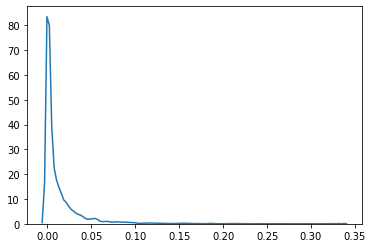

In [30]:
sns.kdeplot(
    pd.Series(
        preds.cpu()
        .numpy()
        .reshape(
            -1,
        )
    )
)

In [31]:
# Saving OOF predictions so stacking would be easier
pd.Series(
    oof.reshape(
        -1,
    )
).to_csv("oof.csv", index=False)

In [32]:
sub = pd.DataFrame(X_test["image_name"])
sub["target"] = (
    preds.cpu()
    .numpy()
    .reshape(
        -1,
    )
)
sub.to_csv("submission.csv", index=False)